Synthesized

# Initialize

In [1]:
%load_ext ipycache
%load_ext autoreload
%autoreload 2

/opt/conda/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/conda/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


In [2]:
import os
import sys

comparisons_folder = os.getcwd()
src_folder = '/'.join(comparisons_folder.split('/')[:-2])
sys.path.insert(0, src_folder)
from src.discoverers.adsorption.values import calc_co2rr_activities


adsorbate = 'CO'
target_energy = -0.67
initial_training_size = 1000
batch_size = 200
quantile_cutoff = 0.9

In [3]:
import random
from multiprocess import Pool
from tqdm import tqdm
import ase.db


db_dir = os.path.join(src_folder, 'notebooks/pull_data/%s_synthesized' % adsorbate)
db_file = os.path.join(db_dir, '%s.db' % adsorbate)
db = ase.db.connect(db_file)
rows = list(tqdm(db.select(), desc='reading ASE db', total=db.count()))
random.Random(42).shuffle(rows)


def parse_row(row):
    feature = row.id
    data = row.data
    label = data['adsorption_energy']
    surface = (data['mpid'], data['miller'], data['shift'], data['top'])
    return feature, label, surface
        
        
def parse_rows(rows): 
    with Pool(processes=32, maxtasksperchild=1000) as pool:
        iterator = pool.imap(parse_row, rows, chunksize=100)
        iterator_tracked = tqdm(iterator, desc='parsing rows', total=len(rows))
        parsed_rows = list(iterator_tracked)

    features, labels, surfaces = list(map(list, zip(*parsed_rows)))
    return features, labels, surfaces


# Data parsing
training_features, training_labels, training_surfaces = parse_rows(rows[:initial_training_size])
sampling_features, sampling_labels, sampling_surfaces = parse_rows(rows[initial_training_size:])

parsing rows: 100%|██████████| 420039/420039 [02:48<00:00, 2498.43it/s]


# Random Sampling Procedures

In [4]:
from src.discoverers.adsorption.randomsearch import RandomSearcher

## Random Sampling with Null Model

In [5]:
cd ../random/null_syn

/home/jovyan/catalyst-acquisitions/notebooks/random/null_syn


In [6]:
from src.discoverers.adsorption.models import NullModel


model = NullModel(db_dir, quantile_cutoff)
rs_null_discoverer = RandomSearcher(model=model,
                                    quantile_cutoff=quantile_cutoff,
                                    value_calculator=calc_co2rr_activities,
                                    batch_size=batch_size,
                                    training_features=training_features,
                                    training_labels=training_labels,
                                    training_surfaces=training_surfaces,
                                    sampling_features=sampling_features,
                                    sampling_labels=sampling_labels,
                                    sampling_surfaces=sampling_surfaces,
                                    init_train=False    # Set to `False` only for warm starts
                                    )

rs_null_discoverer.load_last_run()
#_ = rs_null_discoverer.plot_performance(window=100)

/home/jovyan/catalyst-acquisitions/src/discoverers/adsorption/base.py:812: UserWarning: Tried to set the bulk_values attribute when loading but couldn't
  warnings.warn("Tried to set the %s attribute when loading but couldn't" % key)


## Random sampling with prime model

In [7]:
cd ../prime_syn

/home/jovyan/catalyst-acquisitions/notebooks/random/prime_syn


In [8]:
from src.discoverers.adsorption.models import PrimeModel


model = PrimeModel(db_dir)
rs_prime_discoverer = RandomSearcher(model=model,
                                     quantile_cutoff=quantile_cutoff,
                                     value_calculator=calc_co2rr_activities,
                                     batch_size=batch_size,
                                     training_features=training_features,
                                     training_labels=training_labels,
                                     training_surfaces=training_surfaces,
                                     sampling_features=sampling_features,
                                     sampling_labels=sampling_labels,
                                     sampling_surfaces=sampling_surfaces,
                                     init_train=False    # Set to `False` only for warm starts
                                     )

rs_prime_discoverer.load_last_run()
#_ = rs_prime_discoverer.plot_performance(window=100)

# MMS Procedures

In [9]:
from src.discoverers.adsorption.mms import MultiscaleDiscoverer

## MMS with null model

In [10]:
cd ../../MMS/null_syn

/home/jovyan/catalyst-acquisitions/notebooks/MMS/null_syn


In [11]:
from src.discoverers.adsorption.models import NullModel


model = NullModel(db_dir, quantile_cutoff)
mms_null_discoverer = MultiscaleDiscoverer(model=model,
                                           quantile_cutoff=quantile_cutoff,
                                           value_calculator=calc_co2rr_activities,
                                           batch_size=batch_size,
                                           training_features=training_features,
                                           training_labels=training_labels,
                                           training_surfaces=training_surfaces,
                                           sampling_features=sampling_features,
                                           sampling_labels=sampling_labels,
                                           sampling_surfaces=sampling_surfaces,
                                           init_train=False  # Set to `False` only for warm starts
                                           )

mms_null_discoverer.load_last_run()
#_ = mms_null_discoverer.plot_performance(window=100)

/home/jovyan/catalyst-acquisitions/src/discoverers/adsorption/base.py:812: UserWarning: Tried to set the bulk_values attribute when loading but couldn't
  warnings.warn("Tried to set the %s attribute when loading but couldn't" % key)


## MMS with prime

In [12]:
cd ../prime_syn

/home/jovyan/catalyst-acquisitions/notebooks/MMS/prime_syn


In [13]:
from src.discoverers.adsorption.models import PrimeModel


model = PrimeModel(db_dir)
mms_prime_discoverer = MultiscaleDiscoverer(model=model,
                                            quantile_cutoff=quantile_cutoff,
                                            value_calculator=calc_co2rr_activities,
                                            batch_size=batch_size,
                                            training_features=training_features,
                                            training_labels=training_labels,
                                            training_surfaces=training_surfaces,
                                            sampling_features=sampling_features,
                                            sampling_labels=sampling_labels,
                                            sampling_surfaces=sampling_surfaces,
                                            init_train=False    # Set to `False` only for warm starts
                                            )

mms_prime_discoverer.load_last_run()
#_ = mms_prime_discoverer.plot_performance(window=100)

# Caching

In [14]:
cd /home/jovyan/catalyst-acquisitions/notebooks/comparisons

/home/jovyan/catalyst-acquisitions/notebooks/comparisons


In [3]:
%%cache discoverers_synthesized.pkl rs_null_discoverer rs_prime_discoverer mms_null_discoverer mms_prime_discoverer

rs_null_discoverer = rs_null_discoverer
rs_prime_discoverer = rs_prime_discoverer
mms_null_discoverer = mms_null_discoverer
mms_prime_discoverer = mms_prime_discoverer

[Skipped the cell's code and loaded variables mms_null_discoverer, mms_prime_discoverer, rs_null_discoverer, rs_prime_discoverer from file '/home/jovyan/catalyst-acquisitions/notebooks/comparisons/discoverers_synthesized.pkl'.]


# Comparison

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns


FORMATTER = ticker.FuncFormatter(lambda x, p: format(int(x), ','))
FIG_SIZE = (6.5, 2.5)
#FIG_SIZE = (13, 5)


def plot_rolling_metric(ax, metric_values, metric_name, label=None,
                        window=200, smoother='mean', unit='', **kwargs):
    '''
    Helper function to plot model performance metrics across time in
    hallucination.

    Args:
        ax              Matplotlib ax object to plot onto
        metric_values   A sequence of floats that will be plotted against
                        batch number in the hallucination.
        metric_name     A string indicating what you want the values to be
                        labeled as in the plots.
        label           A string indicating the label you want to use for
                        the data
        window          How many points to roll over during each iteration
        smoother        String indicating how you want to smooth the
                        residuals over the course of the hallucination.
                        Corresponds exactly to the methods of the
                        `pandas.DataFrame.rolling` class, e.g., 'mean',
                        'median', 'min', 'max', 'std', 'sum', etc.
        unit            [Optional] String indicating the units you want to
                        label the plot with
        kwargs          Keyword arguments to pass to `sns.lineplot`
    '''
    # Format the data
    df = pd.DataFrame(metric_values, columns=[metric_name])
    rolling_residuals = getattr(df, metric_name).rolling(window=window)
    rolled_values = getattr(rolling_residuals, smoother)().values
    query_numbers = list(range(len(rolled_values)))

    # Create and format the figure
    _ = sns.lineplot(query_numbers, rolled_values, ax=ax, label=label, **kwargs)
    _ = ax.set_xlabel('Number of discovery queries')
    if unit:
        unit = ' [' + unit + ']'
    _ = ax.set_ylabel('Rolling %s of \n%s%s' % (smoother, metric_name, unit))
    _ = ax.set_xlim([query_numbers[0], query_numbers[-1]])
    _ = ax.set_ylim([0., np.nanmax(rolled_values) * 1.1])
    _ = fig.set_size_inches(*FIG_SIZE)
    _ = ax.get_xaxis().set_major_formatter(FORMATTER)
    return fig

## F1 Score

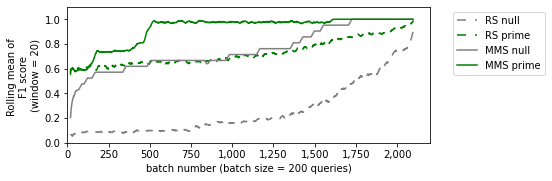

In [6]:
fig = plt.figure()
ax = fig.gca()
window = 20

_ = plot_rolling_metric(ax=ax,
                        metric_values=rs_null_discoverer.reward_history,
                        label='RS null',
                        metric_name='F1 score',
                        unit='',
                        window=window,
                        color='gray')
_ = plot_rolling_metric(ax=ax,
                        metric_values=rs_prime_discoverer.reward_history,
                        label='RS prime',
                        metric_name='F1 score',
                        unit='',
                        window=window,
                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=mms_null_discoverer.reward_history,
                        label='MMS null',
                        metric_name='F1 score',
                        unit='',
                        window=window,
                        color='gray')
_ = plot_rolling_metric(ax=ax,
                        metric_values=mms_prime_discoverer.reward_history,
                        label='MMS prime',
                        metric_name='F1 score',
                        unit='',
                        window=window,
                        color='green')

#_ = ax.set_ylim(0., 1.2)
for line in ax.lines[:2]:
    line.set_linestyle('--')
    line.set_dashes((6, 6))
_ = ax.set_xlim(0, 2200)
_ = ax.set_ylim(0, 1.1)
_ = ax.set_xlabel('batch number (batch size = 200 queries)')
_ = ax.set_ylabel('Rolling mean of \nF1 score \n(window = %i)' % window)
_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax.get_xaxis().set_major_formatter(FORMATTER)

# Save
_ = plt.savefig('../../MMS_manuscript/figures/hallucinations/synthesized/F1.pdf',
                bbox_inches='tight', transparent=True, dpi=600)

## Proxy reward

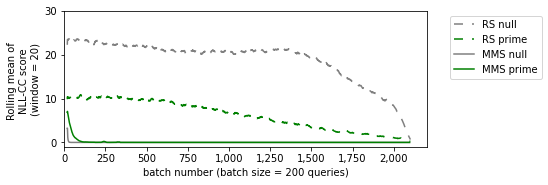

In [8]:
fig = plt.figure()
ax = fig.gca()
window = 20

_ = plot_rolling_metric(ax=ax,
                        metric_values=rs_null_discoverer.proxy_reward_history,
                        label='RS null',
                        metric_name='NLL-CC',
                        unit='',
                        window=window,
                        color='gray')
_ = plot_rolling_metric(ax=ax,
                        metric_values=rs_prime_discoverer.proxy_reward_history,
                        label='RS prime',
                        metric_name='NLL-CC',
                        unit='',
                        window=window,
                        color='green')
_ = plot_rolling_metric(ax=ax,
                        metric_values=mms_null_discoverer.proxy_reward_history,
                        label='MMS null',
                        metric_name='NLL-CC',
                        unit='',
                        window=window,
                        color='gray')
_ = plot_rolling_metric(ax=ax,
                        metric_values=mms_prime_discoverer.proxy_reward_history,
                        label='MMS prime',
                        metric_name='NLL-CC',
                        unit='',
                        window=window,
                        color='green')

#_ = ax.set_ylim(0., 1.2)
for line in ax.lines[:2]:
    line.set_linestyle('--')
    line.set_dashes((6, 6))
_ = ax.set_xlim(0, 2200)
_ = ax.set_ylim(-1, 30)
_ = ax.set_xlabel('batch number (batch size = 200 queries)')
_ = ax.set_ylabel('Rolling mean of \nNLL-CC score \n(window = %i)' % window)
_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
_ = fig.set_size_inches(*FIG_SIZE)
_ = ax.get_xaxis().set_major_formatter(FORMATTER)

# Save
_ = plt.savefig('../../MMS_manuscript/figures/hallucinations/synthesized/NLLCC.pdf',
                bbox_inches='tight', transparent=True, dpi=600)

# Comparing F1 score and proxy reward

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()


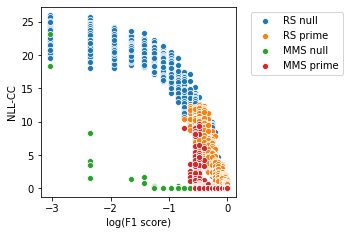

In [9]:
fig = plt.figure(figsize=(3.5, 3.5))
ax = fig.gca()

f1_scores = {'RS null': rs_null_discoverer.reward_history,
             'RS prime': rs_prime_discoverer.reward_history,
             'MMS null': mms_null_discoverer.reward_history,
             'MMS prime': mms_prime_discoverer.reward_history}

nllccs = {'RS null': rs_null_discoverer.proxy_reward_history,
          'RS prime': rs_prime_discoverer.proxy_reward_history,
          'MMS null': mms_null_discoverer.proxy_reward_history,
          'MMS prime': mms_prime_discoverer.proxy_reward_history}

for key, f1s in f1_scores.items():
    nlls = nllccs[key]
    f1s = np.log(f1s)
    _ = sns.scatterplot(f1s, nlls, label=key)

_ = ax.set_xlabel('log(F1 score)')
_ = ax.set_ylabel('NLL-CC')
_ = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Save
_ = plt.savefig('../../MMS_manuscript/figures/hallucinations/synthesized/F1_vs_NLLCC.pdf',
                bbox_inches='tight', transparent=True, dpi=600)